# Assignment 11: Adversarial Training

In this assignment, we will show that adversarial training provides stability against adversarial attacks for the MNIST dataset.
We will compare three different types of training procedures:

1. Train with only the original samples
2. Train with original samples and added random noise
3. Train with original samples and adversarial samples generated by Fast Gradient Sign (FGS) method

Note that the results of this experiment might not translate well to other datasets.

## Dataset and Model

For our experiments, we come back to the dataset and the model that we have used before. 
Particularly, we train and test our methods on the MNIST dataset, using the same deep network structure as in previous exercises.

### Task 1: Dataset

Instantiate the training and validation set splits of MNIST, including data loaders. Select appropriate batch sizes for training and validation sets.

In [1]:
import torch
import torchvision

# training set and data loader
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size=64, shuffle=True)

# validation set and data loader
validation_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9912422/9912422 [00:00<00:00, 184679160.13it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107867937.51it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 99829545.11it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4601577.00it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Task 2: Classification Network

Use the same small-scale network as we have done in Assignment 8. 

Implement a network with two convolutional and two fully-connected layers.
Each convolution with kernel size $5\times5$ is followed by a $2\times2$ maximum pooling and a ReLU activation.
Select appropriate numbers of input and output channels for the convolutions.
The first fully-connected layer reduces the feature map to a certain size, which can be selected freely, while the second layer produces $O=10$ logits.

Note:

* You can also build your network with `torch.nn.Sequential`.

In [2]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=(5,5), stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=(5,5), stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(in_features=49*Q2, out_features=K)
    self.fc2 = torch.nn.Linear(in_features=K, out_features=O)

  
  def forward(self,x):
    return self.fc2(self.fc1(self.flatten(self.act(self.pool(self.conv2(self.act(self.pool(self.conv1(x)))))))))

## Image Manipulation

We implement two different ways to manipulate the images for generating additional training data.
The first way is to compute adversarial samples using the Fast Gradient Sign method.
Here, we want to adapt the image such that we maximize the loss between the network output and the target.
For this purpose, we need to compute the FGS adversarial samples by using the derivative of the loss with respect to the image:

$$\mathbf X_{\mathrm{FGS}} = \mathbf X + \alpha\cdot \mathrm{sign}(\nabla_{\mathbf X})$$

with

$$\nabla_{\mathbf X} = \frac{\partial \mathcal J^{\mathrm{CCE}}}{\partial \mathbf X} $$

As an optional task, we can implement the Fast Gradient Value method,

$$\mathbf X_{\mathrm{FGV}} = \mathbf X + \alpha\cdot\frac{\nabla_{\mathbf X}} {\mathrm{max} |\nabla_{\mathbf X}|}$$

and the generated adversarial samples will be used only in the validation, not training, to check that whether the network trained with FGS is also robust to FGV samples.

The second type of manipulation, similar to Assignment 9, is to add simple noise that represents the same type and magnitude of manipulations as FGS, i.e., we want our noisy image to be:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \{-1,1\}^{D\times E}$$ 

where $D$ and $E$ are the width and the height of the original image. $-1$ and $1$ are sampled with the same probability and independently for each pixel, e.g., using a Bernoulli distribution,.

In order to represent actual images, we will restrict the pixel values of both $\mathbf X_{\mathrm{FGS}}$ and $\mathbf X_{\mathrm{noise}}$ to be in the range $[0,1]$ by clipping any value that is outside that range.

### Task 3: Fast Gradient Sign

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGS}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.


In [41]:
def FGS(x, t, network, loss, alpha=0.3):
  # tell autograd that we need the gradient for the input
  X = x.to(device)
  X.requires_grad_(True)
  # forward input
  z = network(X)
  # compute loss and gradient
  J = loss(z, t.to(device))
  J.backward()

  # get the gradient
  gradient = X.grad
  # create FGS adversarial sampl

  # create FGS adversarial sample
  adversarial_sample = torch.clamp(x + alpha*torch.sign(gradient), min=0, max=1)
  
  return adversarial_sample

### (Optional) Task 3a: Fast Gradient Value

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGV}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.

In [37]:
def FGV(x, t, network, loss, alpha=0.6):
  # tell autograd that we need the gradient for the input
  X = x.to(device)
  X.requires_grad = True
  # forward input
  z = network(X)
  # compute loss and gradient
  J = loss(z, t.to(device))
  J.backward()

  # get the gradient
  gradient = x.grad
  # create FGV adversarial sample by dividing the gradient by the maximum gradient value
  adversarial_sample = x + alpha * gradient / gradient.abs().max()

  # restrict output to [0,1]
  adversarial_sample = torch.clamp(adversarial_sample, 0, 1)
  
  return adversarial_sample

### Task 4: Random Noise

Implement a function that computes the noisy sample according to the definition of $\mathbf X_{\mathrm{noise}}$ shown above, and restricts the output values to be in the range $[0,1]$.


Note that this function will also be used with batches of samples.

In [42]:
import numpy as np

def noise(x, alpha=0.3):
  x = x.to(device)
  # generate noise
  N = torch.randint(low=0, high=1, size=x.shape, device=device)
  N[N==0] = -1
  # Add noise and clamp
  noisy_sample = torch.clamp(x+alpha*N, min=0, max=1)

  return noisy_sample

### Test 1: Adversarial Samples and Noisy Samples

Verify the generated $\mathbf X_{\mathrm{FGS}}$ (and $\mathbf X_{\mathrm{FGV}}$) and $\mathbf X_{\mathrm{noise}}$ have the same shape as $\mathbf X$ and all pixels are ranged in $[0,1]$.

Visualize $\mathbf X$, $\mathbf X_{\mathrm{FGS}}$, and $\mathbf X_{\mathrm{noise}}$.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# create network
network = Network(32,64,10,10).to(device)

loss = torch.nn.CrossEntropyLoss()

# use first validation batch
x, t = next(iter(validation_loader))

# Check the noisy samples: correct shape and range
x_noise = noise(x.to(device), alpha=0.3)
assert x_noise.shape == x.shape
assert torch.all(x_noise >= 0) and torch.all(x_noise <= 1)

# Check the generated adversarial samples: correct shape and range
x_fgs = FGS(x.to(device), t.to(device), network, loss, alpha=0.3)
assert x_fgs.shape == x.shape
assert torch.all(x_fgs >= 0) and torch.all(x_fgs <= 1)

In [9]:
# if you implement FGV, then apply the same check for FGV as well
x_fgv = FGV(x.to(device), t.to(device), network, loss, alpha=1.2)
assert x_fgv.shape == x.shape
assert torch.all(x_fgv >= 0) and torch.all(x_fgv <= 1)

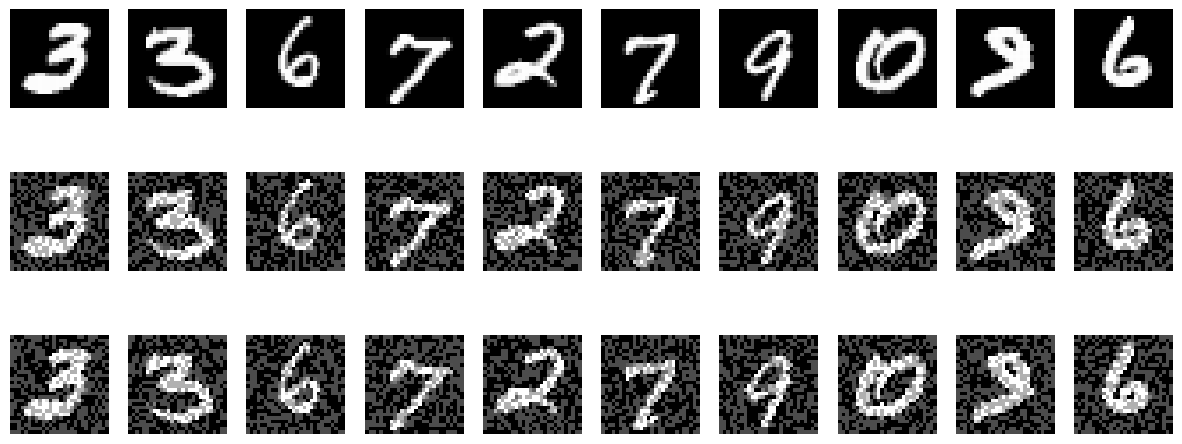

In [49]:
samples = [x.cpu().detach().numpy(), x_fgs.cpu().detach().numpy(), x_noise.cpu().detach().numpy()]

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=3, ncols=10, figsize=(15, 6))

for i in range(3):
    for j in range(10):
      axes[i][j].imshow(samples[i][j].squeeze())
      axes[i][j].axis("off")

## Training and Evaluation

We will implement three different variations of the training procedure, which will be combined into one function.
In all three variations, we will iterate over all batches in the training set and train the network with standard categorical cross-entropy loss.
Variation 1 will only perform the **standard training**.
Variation 2 will generate **FGS adversarial samples** for all images in the batch, and perform an **additional weight update step** after training with the adversarial samples while assigning the original targets.
In variation 3, we will also train with additional data, but instead of generating adversarial samples, we will just **add noise to our images**.

For evaluation, we will compute two different measures.
First, we compute the **classification accuracy** of the network on the clean, unperturbed images of the validation set.
Additionally, we will create adversarial samples via our FGS (or FGV) technique for **all correctly classified validation set samples** and assess how many of these **adversarial samples are classified as their original class** by the network.

### Task 5: Training Loop

For a given network, loss and optimizer, implement a function that trains the network for one epoch on the training data.
If desired by the `add_additional_samples` parameter, implement variation 1, 2, or 3.
Perform update steps where they fit.


In [46]:
def training_loop(network, loss, optimizer, add_additional_samples = None, alpha=0.3):
  for x,t in train_loader:
    optimizer.zero_grad()
    # compute output for current batch
    z = network(x.to(device))
    # compute loss
    J = loss(z, t.to(device))
    # compute gradient
    J.backward()
    # update parameters
    optimizer.step()

    if add_additional_samples is not None:
      # compute modified samples for batch
      if add_additional_samples == "FGS":
        # create FGS adversarial samples
        x_hat = FGS(x.to(device), t.to(device), network, loss, alpha=alpha)
      elif add_additional_samples == "FGV":
        # create FGS adversarial samples
        x_hat = FGV(x.to(device), t.to(device), network, loss, alpha=alpha)
      else:
        # create noisy samples
        x_hat = noise(x.to(device), alpha=alpha)

      optimizer.zero_grad()
      # compute output for modified samples
      z_hat = network(x_hat)
      # compute loss on modified samples
      J = loss(z_hat, t.to(device))
      # compute gradient
      J.backward()
      # update parameters
      optimizer.step()

### Task 6: Validation Loop


For a given network and loss function, iterate over the validation set and compute the classification accuracy on the original validation set samples.

For each batch, select the correctly classified images, and generate adversarial samples for these. 
The flag `FGV_sample` is to control which type of adversarial samples that should be generated here: FGS if `False`, FGV if `True`. 

Finally, compute how many of the adversarial samples are still classified as the original class by the network.

In [39]:
def validation_loop(network, loss, alpha=0.3, FGV_sample=False):
  total, correct_clean_count, correct_adversarial_count = 0,0,0

  # iterate over validation set samples
  for x,t in validation_loader:
    with torch.no_grad():
      x = x.to(device)
      t = t.to(device)
      total += x.shape[0]
      # classify original samples
      z = network(x)
      p = torch.nn.functional.softmax(z, dim=1)

      # compute classification accuracy on original samples
      correct_clean_count += sum(torch.argmax(p, dim=1) == t).item()

    # select the correctly classified samples
    x_correct = x[torch.argmax(p, dim=1) == t].to(device)
    t_correct = t[torch.argmax(p,dim=1) == t].to(device)

    # create adversarial samples using FGS or FGV
    x_attack = FGS(x_correct, t_correct, network, loss, alpha) if not FGV_sample else FGV(x_correct, t_correct, network, loss, alpha)

    # check how many are correctly classified
    with torch.no_grad():
      # classify adversarial samples
      z_attack = network(x_attack)
      p_attack = torch.nn.functional.softmax(z_attack, dim=1)

      # compute classification accuracy on adversarial samples
      correct_adversarial_count += sum(torch.argmax(p_attack,dim=1)==t_correct)
      

  # compute clean and adversarial accuracy and return them
  clean_accuracy = correct_clean_count / total
  correct_adversarial_count = correct_adversarial_count.item()
  adversarial_accuracy = correct_adversarial_count / total / clean_accuracy
  print("Clean acc: ", clean_accuracy, " , Adv. acc: ", adversarial_accuracy)
  return clean_accuracy, adversarial_accuracy

### Task 7: Training of Three Networks

Instantiate three networks, one to train with only clean samples, one to additionally train with adversarial samples, and one to additionally train with noise.

Instantiate corresponding optimizers that train these networks. Make use of SGD with an appropriate learning rate $\eta$ and categorical cross-entropy loss.

Train each of the three networks for 10 epochs (or more) using their specific data extension.

Compute and store the validation set accuracy on the clean and adversarial samples -- note that adversarial samples will be generated for each network separately -- after each training epoch. 
Hence, the training time is extended as compared to normal training since the creation of adversarial samples requires time.


In [43]:
# define one network for each training procedure
networks = {"clean": Network(32,32,20,10).to(device), "FGS": Network(32,32,20,10).to(device), "noise": Network(32,32,20,10).to(device)}
# define optimizer
optimizer_clean = torch.optim.SGD(params=networks["clean"].parameters(),lr=0.005)
optimizer_FGS = torch.optim.SGD(params=networks["FGS"].parameters(),lr=0.005)
optimizer_noise = torch.optim.SGD(params=networks["noise"].parameters(),lr=0.005)

# define loss function
loss = torch.nn.CrossEntropyLoss()

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies = {"clean": [], "FGS": [], "noise": []}
adversarial_accuracies = {"clean": [], "FGS": [], "noise": []}

# iterate over 10 epochs (or more)
for epoch in range(10):
  # perform training loop
  training_loop(networks["clean"], loss, optimizer_clean)
  training_loop(networks["FGS"], loss, optimizer_FGS, add_additional_samples="FGS")
  training_loop(networks["noise"], loss, optimizer_noise, add_additional_samples="noise")

  # compute and store validation set accuracies for each network
  clean_accuracy, adversarial_accuracy = validation_loop(networks["clean"], loss, FGV_sample=False)
  clean_accuracies["clean"].append(clean_accuracy)
  adversarial_accuracies["clean"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks["FGS"], loss, FGV_sample=False)
  clean_accuracies["FGS"].append(clean_accuracy)
  adversarial_accuracies["FGS"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks["noise"], loss, FGV_sample=False)
  clean_accuracies["noise"].append(clean_accuracy)
  adversarial_accuracies["noise"].append(adversarial_accuracy)

  print("Epoch: ", epoch)

Clean acc:  0.8885  , Adv. acc:  0.0029262802476083287
Clean acc:  0.9509  , Adv. acc:  0.347986118414134
Clean acc:  0.9145  , Adv. acc:  0.004592673592126845
Epoch:  0
Clean acc:  0.9212  , Adv. acc:  0.0007598784194528875
Clean acc:  0.9625  , Adv. acc:  0.41942857142857143
Clean acc:  0.9557  , Adv. acc:  0.0011509888040179973
Epoch:  1
Clean acc:  0.9349  , Adv. acc:  0.0003208899347523799
Clean acc:  0.9707  , Adv. acc:  0.5006696198619552
Clean acc:  0.9708  , Adv. acc:  0.005356407086938607
Epoch:  2
Clean acc:  0.948  , Adv. acc:  0.0005274261603375528
Clean acc:  0.9711  , Adv. acc:  0.5275460817629493
Clean acc:  0.9736  , Adv. acc:  0.011811832374691866
Epoch:  3
Clean acc:  0.9565  , Adv. acc:  0.0007318348144276006
Clean acc:  0.9742  , Adv. acc:  0.5673373024019709
Clean acc:  0.9756  , Adv. acc:  0.017732677326773267
Epoch:  4
Clean acc:  0.9638  , Adv. acc:  0.0008300477277443454
Clean acc:  0.9771  , Adv. acc:  0.6081260874014942
Clean acc:  0.9774  , Adv. acc:  0.031

### (Optional) Task 7a: Training of Three Networks and check the performance on FGV samples

Follow the exact same setup as Task 7.

Compute and store the validation set accuracy on the clean and FGV adversarial samples. Remember to set a higher $\alpha$ when generating FGV samples (at least $\times 2$ to the FGS $\alpha$).

In [47]:
# define one network for each training procedure
networks_FGV = {"clean": Network(32,32,20,10).to(device), "FGV": Network(32,32,20,10).to(device), "noise": Network(32,32,20,10).to(device)}
# define optimizer
optimizer_clean = torch.optim.SGD(params=networks_FGV["clean"].parameters(),lr=0.005)
optimizer_FGV = torch.optim.SGD(params=networks_FGV["FGV"].parameters(),lr=0.005)
optimizer_noise = torch.optim.SGD(params=networks_FGV["noise"].parameters(),lr=0.005)

# define loss function
loss = torch.nn.CrossEntropyLoss()

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies_FGV = {"clean": [], "FGV": [], "noise": []}
adversarial_accuracies_FGV = {"clean": [], "FGV": [], "noise": []}

# iterate over 10 epochs (or more)
for epoch in range(10):
  # perform training loop
  training_loop(networks_FGV["clean"], loss, optimizer_clean, alpha=0.6)
  training_loop(networks_FGV["FGV"], loss, optimizer_FGV, alpha=0.6, add_additional_samples="FGV")
  training_loop(networks_FGV["noise"], loss, optimizer_noise, alpha=0.6, add_additional_samples="noise")

  # compute and store validation set accuracies
  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["clean"], loss, FGV_sample=True)
  clean_accuracies_FGV["clean"].append(clean_accuracy)
  adversarial_accuracies_FGV["clean"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["FGV"], loss, FGV_sample=True)
  clean_accuracies_FGV["FGV"].append(clean_accuracy)
  adversarial_accuracies_FGV["FGV"].append(adversarial_accuracy)

  clean_accuracy, adversarial_accuracy = validation_loop(networks_FGV["noise"], loss, FGV_sample=True)
  clean_accuracies_FGV["noise"].append(clean_accuracy)
  adversarial_accuracies_FGV["noise"].append(adversarial_accuracy)
  

Clean acc:  0.8652  , Adv. acc:  0.8112575127138234
Clean acc:  0.9196  , Adv. acc:  0.8800565463244889
Clean acc:  0.8943  , Adv. acc:  0.8875097841887509
Clean acc:  0.918  , Adv. acc:  0.8652505446623093
Clean acc:  0.9552  , Adv. acc:  0.9327889447236181
Clean acc:  0.9319  , Adv. acc:  0.9267088743427407
Clean acc:  0.9314  , Adv. acc:  0.8904874382649774
Clean acc:  0.972  , Adv. acc:  0.9493827160493827
Clean acc:  0.9465  , Adv. acc:  0.940095087163233
Clean acc:  0.9459  , Adv. acc:  0.9125700391161856
Clean acc:  0.9739  , Adv. acc:  0.9523565047746175
Clean acc:  0.9615  , Adv. acc:  0.9544461778471138
Clean acc:  0.9583  , Adv. acc:  0.9223625169571116
Clean acc:  0.9757  , Adv. acc:  0.9568514912370606
Clean acc:  0.9702  , Adv. acc:  0.9605236033807463
Clean acc:  0.963  , Adv. acc:  0.9333333333333335
Clean acc:  0.9807  , Adv. acc:  0.9591108391964923
Clean acc:  0.9736  , Adv. acc:  0.9652834839769926
Clean acc:  0.9678  , Adv. acc:  0.9391403182475718
Clean acc:  0.97

### Task 8: Plotting of Accuracies

Generate two plots.

In the first plot, compare the accuracies on the clean images of the validation set over the 10 epochs. (Plot clean accuracies)

In the second plot, compare the stability of the networks w.r.t. adversarial samples, i.e., how many adversarial samples can change the classification of the network. (Plot adversarial accuracies)

Exemplary plots can be found in the slides.


Text(0.5, 1.0, 'Adversarial accuracy')

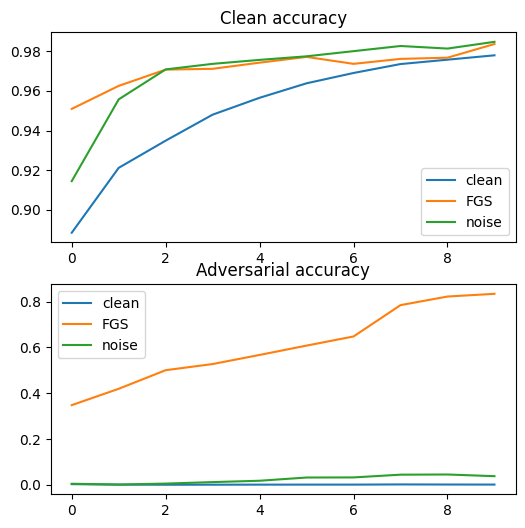

In [44]:
from matplotlib import pyplot

pyplot.figure(figsize=(6,6))

# plot clean accuracies
pyplot.subplot(211)
pyplot.plot(clean_accuracies["clean"], label="clean")
pyplot.plot(clean_accuracies["FGS"], label="FGS")
pyplot.plot(clean_accuracies["noise"], label="noise")
pyplot.legend()
pyplot.title("Clean accuracy")


# plot adversarial accuracies
pyplot.subplot(212)
pyplot.plot(adversarial_accuracies["clean"], label="clean")
pyplot.plot(adversarial_accuracies["FGS"], label="FGS")
pyplot.plot(adversarial_accuracies["noise"], label="noise")
pyplot.legend()
pyplot.title("Adversarial accuracy")

### (Optional) Task 8a: Plotting of Accuracies

Follow the exact same setup as Task 8. This time, plot the validation accuracy on FGV samples instead.

Text(0.5, 1.0, 'Adversarial accuracy')

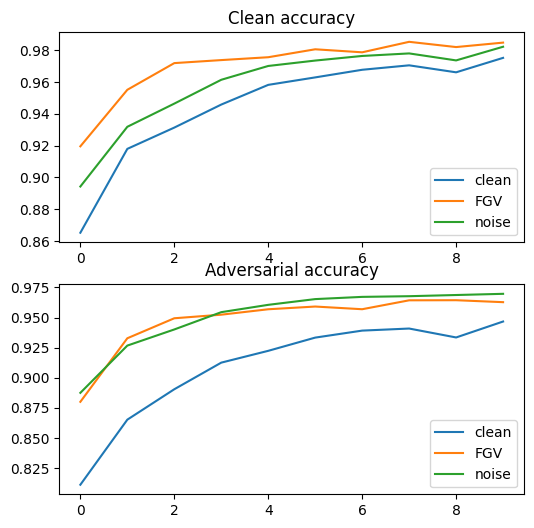

In [48]:
from matplotlib import pyplot

pyplot.figure(figsize=(6,6))

# plot clean accuracies
pyplot.subplot(211)
pyplot.plot(clean_accuracies_FGV["clean"], label="clean")
pyplot.plot(clean_accuracies_FGV["FGV"], label="FGV")
pyplot.plot(clean_accuracies_FGV["noise"], label="noise")
pyplot.legend()
pyplot.title("Clean accuracy")

# plot adversarial accuracies
pyplot.subplot(212)
pyplot.plot(adversarial_accuracies_FGV["clean"], label="clean")
pyplot.plot(adversarial_accuracies_FGV["FGV"], label="FGV")
pyplot.plot(adversarial_accuracies_FGV["noise"], label="noise")
pyplot.legend()
pyplot.title("Adversarial accuracy")